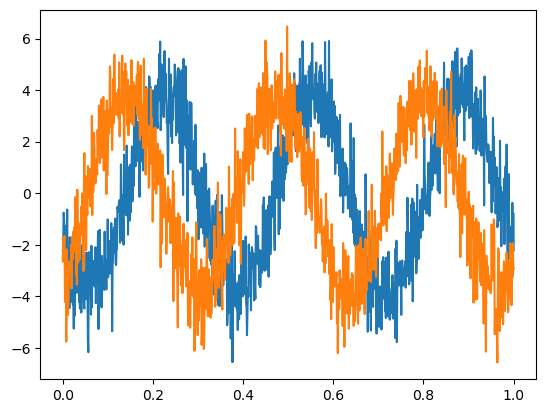

torch.Size([1024, 2])


In [1]:
from gaps.datamodules import SinusoidsDataset
import matplotlib.pyplot as plt
import numpy as np

dataset = SinusoidsDataset(10)
params, signal = dataset[0]
for s in signal.T:
    plt.plot(dataset.times, s)
plt.show()
print(signal.shape)

In [2]:
from networks.timeseries import Mamba
model = Mamba(input_dim=2,hidden_dim=32, num_layers=2, state_dim=32)
print(model)

signal = signal.to("cuda")
model.to("cuda")

print(signal.shape, signal.device)
y = model(signal[None, ...])
print(y.shape)

Mamba(
  (embedding): Linear(in_features=2, out_features=32, bias=False)
  (layers): ModuleList(
    (0-1): 2 x Block(
      (mixer): Mamba(
        (in_proj): Linear(in_features=32, out_features=128, bias=False)
        (conv1d): Conv1d(64, 64, kernel_size=(4,), stride=(1,), padding=(3,), groups=64)
        (act): SiLU()
        (x_proj): Linear(in_features=64, out_features=66, bias=False)
        (dt_proj): Linear(in_features=2, out_features=64, bias=True)
        (out_proj): Linear(in_features=64, out_features=32, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (norm_f): RMSNorm()
)
torch.Size([1024, 2]) cuda:0
torch.Size([1, 1024, 32])


In [5]:
import torch
import torch.nn as nn
from networks.utils import MLP
from networks.timeseries import Mamba, DownSample


class Generator(nn.Sequential):
    def __init__(self, signal_shape, params_size, hidden_dim=32, **kwargs):
        time, channels = signal_shape

        layers = []
        layers.append(nn.Linear(2 * channels, hidden_dim, bias=False))
        channels = hidden_dim

        for _ in range(3):
            layers.append(Mamba(channels, num_layers=1, state_dim=32))
            layers.append(DownSample(channels, pool=8, expand=2))
            time, channels = time // 8, 2 * channels

        layers.append(MLP(input_dim=time * channels, output_dim=params_size))
        super().__init__(*layers)

    def sample_z(self, signal):
        z = torch.randn_like(signal)
        return z

    def forward(self, signal, z=None):
        if z is None:
            z = self.sample_z(signal)
        x = torch.cat([signal, z], dim=-1)
        return super().forward(x)


class Critic(nn.Sequential):
    def __init__(self, signal_shape, params_size, hidden_dim=32, **kwargs):
        time, channels = signal_shape

        layers = []
        layers.append(nn.Linear(channels + params_size, hidden_dim, bias=False))
        channels = hidden_dim

        for _ in range(3):
            layers.append(Mamba(channels, num_layers=1, state_dim=32))
            layers.append(DownSample(channels, pool=8, expand=2))
            time, channels = time // 8, 2 * channels

        layers.append(MLP(input_dim=time * channels, output_dim=1))
        super().__init__(*layers)

    def forward(self, signal, params):
        *batch, time, channels = signal.shape
        params = params.unsqueeze(-2).expand(*batch, time, -1)
        x = torch.cat([signal, params], dim=-1)
        return super().forward(x)


model = Generator(signal.shape, 3).to("cuda")
a = model(torch.randn(4, *signal.shape).to("cuda"))
print(a.shape)
model = Critic(signal.shape, 3).to("cuda")
a = model(torch.randn(4, *signal.shape).to("cuda"), a)
print(a.shape)

torch.Size([4, 3])
torch.Size([4, 1])
